In [1]:
from collections import namedtuple
import numpy as np


def unbroadcast(target, g, axis=0):
    """Remove broadcasted dimensions by summing along them.
    When computing gradients of a broadcasted value, this is the right thing to
    do when computing the total derivative and accounting for cloning.
    """
    while np.ndim(g) > np.ndim(target):
        g = g.sum(axis=axis)
    for axis, size in enumerate(target.shape):
        if size == 1:
            g = g.sum(axis=axis, keepdims=True)
    if np.iscomplexobj(g) and not np.iscomplex(target):
        g = g.real()
    return g

Op = namedtuple('Op', ['apply',
                   'vjp',
                   'name',
                   'nargs'])

In [2]:
def add_vjp(dldf, a, b):
    dlda = unbroadcast(a, dldf)
    dldb = unbroadcast(b, dldf)
    return dlda, dldb
    
add = Op(
    apply=np.add,
    vjp=add_vjp,
    name='+',
    nargs=2)

In [3]:
def mul_vjp(dldf, a, b):
    dlda = unbroadcast(a, dldf * b)
    dldb = unbroadcast(b, dldf * a)
    return dlda, dldb

mul = Op(
    apply=np.multiply,
    vjp=mul_vjp,
    name='*',
    nargs=2)

In [4]:
def matmul_vjp(dldF, A, B):
    G = dldF
    if G.ndim == 0:
        assert A.ndim == 1 and B.ndim == 1
        dldA = G*B
        dldB = G*A
        return (unbroadcast(A, dldA),
                unbroadcast(B, dldB))
    
    assert not (A.ndim == 1 and B.ndim == 1)

    # 1. If both arguments are 2-D they are multiplied like conventional matrices.
    # 2. If either argument is N-D, N > 2, it is treated as a stack of matrices 
    # residing in the last two indexes and broadcast accordingly.
    if A.ndim >= 2 and B.ndim >= 2:
        dldA = G @ B.swapaxes(-2, -1)
        dldB = A.swapaxes(-2, -1) @ G
    if A.ndim == 1:
        # 3. If the first argument is 1-D, it is promoted to a matrix by prepending a
        #    1 to its dimensions. After matrix multiplication the prepended 1 is removed.
        A_ = A[np.newaxis, :]
        G_ = G[np.newaxis, :]
        dldA = G @ B.swapaxes(-2, -1) 
        dldB = A_.swapaxes(-2, -1) @ G_ # outer product
    elif B.ndim == 1:
        # 4. If the second argument is 1-D, it is promoted to a matrix by appending 
        #    a 1 to its dimensions. After matrix multiplication the appended 1 is removed.
        B_ = B[:, np.newaxis]
        G_ = G[:, np.newaxis]
        dldA = G_ @ B_.swapaxes(-2, -1) # outer product
        dldB = A.swapaxes(-2, -1) @ G
    return (unbroadcast(A, dldA), 
            unbroadcast(B, dldB))
        

matmul = Op(
    apply=np.matmul,
    vjp=matmul_vjp,
    name='@',
    nargs=2)

In [5]:
def exp_vjp(dldf, x):
    dldx = dldf * np.exp(x)
    return (unbroadcast(x, dldx),)
exp = Op(
    apply=np.exp,
    vjp=exp_vjp,
    name='exp',
    nargs=1)

In [6]:
def log_vjp(dldf, x):
    dldx = dldf / x
    return (unbroadcast(x, dldx),)
log = Op(
    apply=np.log,
    vjp=log_vjp,
    name='log',
    nargs=1)

In [7]:
def sum_vjp(dldf, x, axis=None, **kwargs):
    if axis is not None:
        dldx = np.expand_dims(dldf, axis=axis) * np.ones_like(x)
    else:
        dldx = dldf * np.ones_like(x)
    return (unbroadcast(x, dldx),)

sum_ = Op(
    apply=np.sum,
    vjp=sum_vjp,
    name='sum',
    nargs=1)

In [8]:
def maximum_vjp(dldf, a, b):
    dlda = dldf * np.where(a > b, 1, 0)
    dldb = dldf * np.where(b > a, 1, 0)
    return unbroadcast(a, dlda), unbroadcast(b, dldb)

maximum = Op(
    apply=np.maximum,
    vjp=maximum_vjp,
    name='maximum',
    nargs=2)

In [9]:
NoOp = Op(apply=None, name='', vjp=None, nargs=0)
class Tensor:
    __array_priority__ = 100
    def __init__(self, value, grad=None, parents=(), op=NoOp, kwargs={}, requires_grad=True):
        self.value = np.asarray(value)
        self.grad = grad
        self.parents = parents
        self.op = op
        self.kwargs = kwargs
        self.requires_grad = requires_grad
    
    shape = property(lambda self: self.value.shape)
    ndim  = property(lambda self: self.value.ndim)
    size  = property(lambda self: self.value.size)
    dtype = property(lambda self: self.value.dtype)
    
    def __add__(self, other):
        cls = type(self)
        other = other if isinstance(other, cls) else cls(other)
        return cls(add.apply(self.value, other.value),
                   parents=(self, other),
                   op=add)
    __radd__ = __add__
    
    def __mul__(self, other):
        cls = type(self)
        other = other if isinstance(other, cls) else cls(other)
        return cls(mul.apply(self.value, other.value),
                   parents=(self, other),
                   op=mul)
    __rmul__ = __mul__
    
    def __matmul__(self, other):
        cls = type(self)
        other = other if isinstance(other, cls) else cls(other)
        return cls(matmul.apply(self.value, other.value),
                  parents=(self, other),
                  op=matmul)
    
    def exp(self):
        cls = type(self)
        return cls(exp.apply(self.value),
                parents=(self,),
                op=exp)
    
    def log(self):
        cls = type(self)
        return cls(log.apply(self.value),
                parents=(self, ),
                op=log)
    
    def __pow__(self, other):
        cls = type(self)
        other = other if isinstance(other, cls) else cls(other)
        return (self.log() * other).exp()
    
    def __div__(self, other):
        return self * (other**(-1))
    
    def __sub__(self, other):
        return self + (other * (-1))
    
    def __neg__(self):
        return self*(-1)
    
    def sum(self, axis=None):
        cls = type(self)
        return cls(sum_.apply(self.value, axis=axis),
                   parents=(self,),
                   op=sum_,
                   kwargs=dict(axis=axis))

    def maximum(self, other):
        cls = type(self)
        other = other if isinstance(other, cls) else cls(other)
        return cls(maximum.apply(self.value, other.value),
                   parents=(self, other),
                   op=maximum)
        
    def __repr__(self):
        cls = type(self)
        return f"{cls.__name__}(value={self.value}, op={self.op.name})" if self.parents else f"{cls.__name__}(value={self.value})"
        #return f"{cls.__name__}(value={self.value}, parents={self.parents}, op={self.op}"
    
    def backward(self, grad):
        self.grad = grad if self.grad is None else (self.grad+grad)
        if self.requires_grad and self.parents:
            p_vals = [p.value for p in self.parents]
            assert len(p_vals) == self.op.nargs
            p_grads = self.op.vjp(grad, *p_vals, **self.kwargs)
            for p, g in zip(self.parents, p_grads):
                p.backward(g)

In [10]:
Tensor([1, 2]).sum()

Tensor(value=3, op=sum)

In [11]:

try:
    from graphviz import Digraph
except ImportError as e:
    import subprocess
    subprocess.call("!pip install --user graphviz")

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for p in v.parents:
                edges.add((p, v))
                build(p)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        vstr = np.array_str(n.value, precision=4) if not np.isscalar(n.value) else f'{n.value:.4f}'
        gradstr= np.array_str(n.grad, precision=4) if n.grad is not None and not np.isscalar(n.grad) else ''
        dot.node(name=str(id(n)), label = f"{{v={vstr} | g={gradstr}}}", shape='record')
        if n.parents:
            dot.node(name=str(id(n)) + n.op.name, label=n.op.name)
            dot.edge(str(id(n)) + n.op.name, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.op.name)
    
    return dot

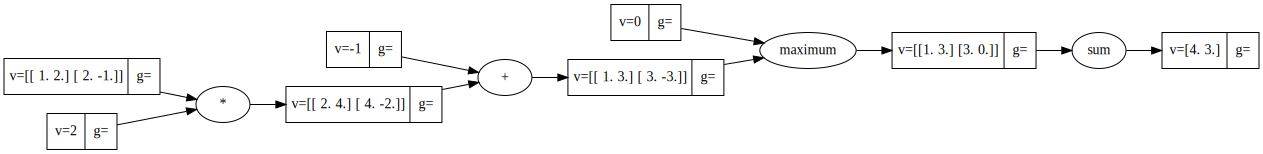

In [12]:
# a very simple example
x = Tensor([[1.0, 2.0],
            [2.0, -1.0]])
y = (x * 2 - 1).maximum(0).sum(axis=-1)
draw_dot(y)

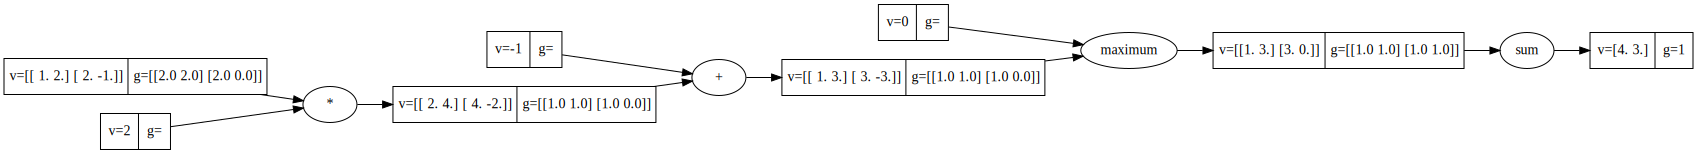

In [13]:
y.backward(np.ones_like(y))
draw_dot(y)

In [14]:
def f_np(x):
    b = [1, 0]
    return (x @ b)*np.exp((-x*x).sum(axis=-1))

def f_T(x):
    b = [1, 0]
    return (x @ b)*(-x*x).sum(axis=-1).exp()

def grad_f(x):
    xT = Tensor(x)
    y = f_T(xT)
    y.backward(np.ones_like(y.value))
    return xT.grad

[-0.00673795 -0.02695179]


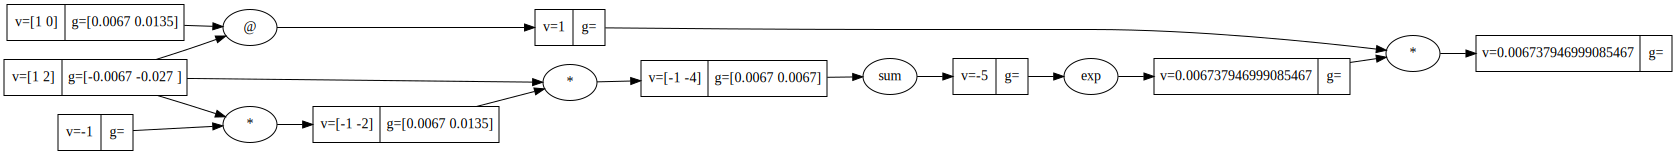

In [15]:
xT = Tensor([1, 2])
out = f_T(xT)
out.backward(1)
print(xT.grad)
draw_dot(out)

In [16]:
def numerical_jacobian(f, x, h=1e-10):
    n = x.shape[-1]
    eye = np.eye(n)
    x_plus_dx = x + h * eye # n x n
    num_jac = (f(x_plus_dx) - f(x)) / h # limit definition of the formula # n x m
    if num_jac.ndim >= 2:
        num_jac = num_jac.swapaxes(-1, -2) # m x n
    return num_jac

# Compare our grad_f with numerical gradient
def check_numerical_jacobian(f, jac_f,  nD=2, **kwargs):
    x = np.random.rand(nD)
    print(x)
    num_jac = numerical_jacobian(f, x, **kwargs)
    print(num_jac)
    print(jac_f(x))
    return np.allclose(num_jac, jac_f(x), atol=1e-06, rtol=1e-4) # m x n

## Throw error if grad_f is wrong
check_numerical_jacobian(f_np, grad_f)

[0.97320668 0.21511288]
[-0.33115732 -0.15504931]
[-0.33115765 -0.15504982]


True